# Monitoring the Training Process

In the previous tutorial we judged the training process by plotting the output of the network. In general we can not directly observe the quality of the network. In this tutorial we will revisit the function approximation problem but monitor the training and testing losses to see how the network is evolving.

In [1]:
# standard libraries
import math, os, time
import numpy as np

# plotting
import matplotlib.pyplot as plt

# progress bars
from tqdm.notebook import trange, tqdm

# PyTorch
import torch
import torch.nn as nn # lets not write out torch.nn every time

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Data & Model

We will take over the data and model from the previous tutorial.

In [2]:
X = torch.arange(0., 1., step=0.01, device=device).unsqueeze(-1)
Y = 0.6 * torch.sin(6*X) * torch.sin(3*X+1) + 0.25

# Create a dataset from existing tensors
dataset = torch.utils.data.TensorDataset(X, Y)

# lets follow best practices and split into training and testing data
# we will split the dataset 80/20
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# now to do the actual splitting
# using generator=torch.manual_seed(0) fixes the RNG so we get a reproducable split
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.manual_seed(0))

In [3]:
hidden = 32 # how many hidden units we want

network = nn.Sequential(
    nn.Linear(1, hidden), # = x A^T + b
    nn.ReLU(), # = ReLU(x A^T + b)
    nn.Linear(hidden, 1, bias=False), # = ReLU(x A^T + b) C^T
)

network = network.to(device)

## Training

What we are going to study is the evolution of the loss as we train our network. We will track the average loss on each batch, the average loss across the training dataset and the average loss over the testing dataset.

The loss on the test dataset `test_data` is the most important. Since the network never gets to see that data it will give us an idea on how well the network has generalized. If there is a large difference between the training and test loss we can conclude that we have an over-fitting problem.

In [4]:
# we also copy the improved initialization scheme we developed previously
network[0].weight.data.fill_(1.0)
torch.arange(start=-1.0, end=0.0, step=1.0/hidden, out=network[0].bias.data)
torch.manual_seed(0)
torch.nn.init.uniform_(network[2].weight, a=-1.0, b=1.0)

# empty lists where we store losses as we train
batch_L2 = []
train_L2 = []
test_L2 = []

In [5]:
EPOCHS = 10000
BATCH_SIZE = 8
LEARNING_RATE = 0.004

# A DataLoader will feed us random (shuffled) batches
loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# we use the SGD optimizer and let it know what parameters it has to consider
optimizer = torch.optim.SGD(network.parameters(), lr=LEARNING_RATE)

from IPython.display import clear_output # for animating the plot

We train the same way as previously but add code for tracking and plotting the losses. The important changes are commented. You can run the cell below repeatedly to keep training or run the above cells to reset the network or change the training setup.

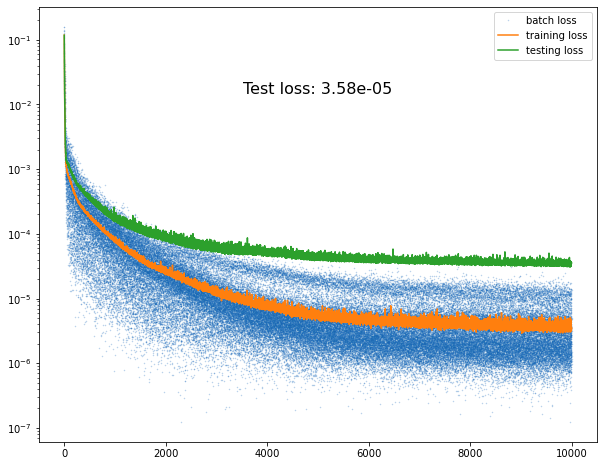

In [6]:
for epoch in range(1, EPOCHS+1):
    
    network.train() 
    
    for x, y in iter(loader):
        optimizer.zero_grad() 
        prediction = network(x) 
        loss = (y - prediction).pow(2).sum()
        batch_L2.append(loss.item() / BATCH_SIZE) # add the avg. batch loss to the list
        loss.backward() 
        optimizer.step() 
    
    network.eval() 
    
    train_L2.append(np.mean(batch_L2[-len(loader):])) # add the avg. of the batch losses of this epoch to the train_L2 list
    
    Xtest, Ytest = test_data[:] # retrieve the test data
    Ypred = network(Xtest)
    test_loss = (Ytest - Ypred).pow(2).sum() / len(test_data) # calculate avg. loss on the test data
    test_L2.append(test_loss.item()) # append test loss to the test_L2 list
    
    
    # Plot every few epochs
    if epoch % 20 == 0 or epoch == EPOCHS:
        clear_output(wait=True)
        plt.figure(figsize=[10, 8])
        plt.yscale('log') # use logarithmic scale on the Y-axis
        
        # since the list of batch losses is much longer than the per epoch losses
        # we have to do some work to get them on the same epoch scale
        plt.plot(
            np.arange(len(batch_L2))*BATCH_SIZE / len(train_data), 
            batch_L2, 
            ".", 
            markersize=1.0, 
            label="batch loss", 
            markerfacecolor=(0, 0, 1, 0.3)
        )
        plt.plot(train_L2, label="training loss")
        plt.plot(test_L2, label="testing loss")
        plt.legend()
        
        # add some text displaying the current test loss
        x_anchor = 0.5 * plt.xlim()[0] + 0.5 * plt.xlim()[1]
        y_anchor = 10**(0.2*math.log10(plt.ylim()[0]) + 0.8*math.log10(plt.ylim()[1]))
        plt.text(x_anchor, y_anchor, f"Test loss: {test_L2[-1]:.2e}", ha='center', fontsize=16)
        
        plt.show()

A couple things to note about this graph:
- The network keeps improving for a very long time, even for this toy problem patience is beneficial.
- Individual batch losses still have a relatively large variance but this is to be expected. What is less expected is the double band that appears. I would conjecture that the top band contains points at both end of the interval (but feel free to investigate this phenomenon yourself).

In any case the losses have gotten very small indeed, lets inspect the result.

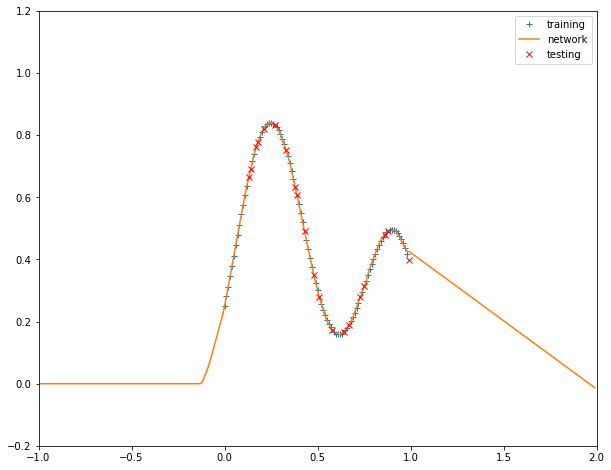

In [7]:
X2 = torch.arange(-1,2,step=0.01, device=device).unsqueeze(-1)
plt.figure(figsize=[10, 8])
plt.plot(train_data[:][0].cpu().squeeze(), train_data[:][1].cpu().squeeze(), '+', label="training")
plt.plot(X2.cpu(), network(X2).detach().cpu(), '-', label="network")
plt.plot(test_data[:][0].cpu().squeeze(), test_data[:][1].cpu().squeeze(), 'xr', label="testing")
plt.legend()
plt.xlim(-1.0, 2.0)
plt.ylim(-0.2, 1.2)
plt.show()

A very good result indeed, there is still a small defect with the rightmost data points but nothing major. The extrapolations are also not unreasonable.

## Optional Exercises

1. Play with the learning rate and batch size above and see if you can speed up the training process.
2. It is logical to monitor the loss during the training, but we may also monitor other performance measures. Copy and modify the above training code to include another performance measure ($L^\infty$ for example). 